 проанализированы метрики количества сообщений по дням/неделям/месяцам, ответы на сообщения, содержания сообщений

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns


загрузим и распарсим историю сообщений канала JAICP (сообщество пользователей)

In [2]:
with open('/content/result.json', 'r') as file:
    data = json.load(file)

In [3]:
for key in data:
    print(key)

name
type
id
messages


In [4]:
messages = data['messages']
df_messages = pd.DataFrame(messages)
df_messages

,id,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,...,file,file_name,mime_type,thumbnail,media_type,sticker_emoji,forwarded_from,via_bot,duration_seconds,poll
0,1,service,2020-10-19T16:03:40,1603112620,JAICP (сообщество пользователей),channel1327552181,migrate_from_group,JAICP (сообщество пользователей),,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,service,2020-10-19T16:06:24,1603112784,Sveta Uvarova,user46791586,edit_group_photo,NaN,,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,message,2020-10-19T16:11:10,1603113070,NaN,NaN,NaN,NaN,[Всем привет! \nСоздала сообщество пользовател...,"[{'type': 'plain', 'text': 'Всем привет! Созд...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,service,2020-10-19T16:11:37,1603113097,Sveta Uvarova,user46791586,pin_message,NaN,,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27,service,2020-10-28T14:40:23,1603885223,Anton Sipachev,user217009532,invite_members,NaN,,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,13663,message,2024-06-06T13:33:20,1717670000,NaN,NaN,NaN,NaN,Добрый день!,"[{'type': 'plain', 'text': 'Добрый день!'}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11951,13664,message,2024-06-06T13:36:03,1717670163,NaN,NaN,NaN,NaN,Подскажите пожалуйста как сделать так чтобы из...,"[{'type': 'plain', 'text': 'Подскажите пожалуй...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11952,13665,message,2024-06-06T13:37:40,1717670260,NaN,NaN,NaN,NaN,все стейты тут для примера,"[{'type': 'plain', 'text': 'все стейты тут для...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11953,13671,message,2024-06-06T15:06:35,1717675595,NaN,NaN,NaN,NaN,А в стейте Goods нельзя ли прописать тег q: с ...,"[{'type': 'plain', 'text': 'А в стейте Goods н...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим какие есть столбцы

In [ ]:
df_messages.columns

Index(['id', 'type', 'date', 'date_unixtime', 'actor', 'actor_id', 'action',
       'title', 'text', 'text_entities', 'photo', 'width', 'height', 'edited',
       'edited_unixtime', 'from', 'from_id', 'message_id', 'members', 'author',
       'reply_to_message_id', 'file', 'file_name', 'mime_type', 'thumbnail',
       'media_type', 'sticker_emoji', 'forwarded_from', 'via_bot',
       'duration_seconds', 'poll'],
      dtype='object')

In [ ]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11955 entries, 0 to 11954
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11955 non-null  int64  
 1   type                 11955 non-null  object 
 2   date                 11955 non-null  object 
 3   date_unixtime        11955 non-null  object 
 4   actor                1005 non-null   object 
 5   actor_id             1117 non-null   object 
 6   action               1117 non-null   object 
 7   title                1 non-null      object 
 8   text                 11955 non-null  object 
 9   text_entities        11955 non-null  object 
 10  photo                809 non-null    object 
 11  width                961 non-null    float64
 12  height               961 non-null    float64
 13  edited               1553 non-null   object 
 14  edited_unixtime      1553 non-null   object 
 15  from                 10777 non-null 

Столбцы, где много нанов (больше 50%), неинформативны для нас. Так что удалим их первым делом

столбцы Title, message_id, via_bot, duration_seconds содержат много пустых значений. sticker_emoji - не релевантен для нас

In [ ]:
df_messages['message_id'].value_counts()

message_id
3.0        1
149.0      1
2790.0     1
10402.0    1
Name: count, dtype: int64

In [ ]:
df_messages['author'].value_counts()

author
Product manager    789
Just AI Team         6
Name: count, dtype: int64

In [ ]:
df_messages['forwarded_from'].value_counts()

forwarded_from
Aimylogic. News and updates             49
Alex                                    14
Tinkoff VoiceKit News                    4
Roman Antipov                            3
Иван Дмитриев                            3
Динислам Закиров                         2
Vlad                                     2
Руслан Глазков                           2
Stepan                                   2
Andrey                                   2
Pauline Smolina                          2
Алексей Леонтьев                         2
Евгений Самсонов                         1
Aimylogic (сообщество пользователей)     1
Vladimir Privalov                        1
Lju                                      1
Бесплатное обучение Conversation AI      1
Екатерина                                1
Павел                                    1
Данила                                   1
Evgeniy Kish                             1
/exit                                    1
Conversations Club                     

In [ ]:
df_messages['via_bot'].value_counts()

via_bot
@gif    1
Name: count, dtype: int64

In [ ]:
df_messages['duration_seconds'].value_counts()

duration_seconds
4.0     1
61.0    1
2.0     1
66.0    1
27.0    1
3.0     1
11.0    1
Name: count, dtype: int64

In [ ]:
df_messages['poll'].value_counts()

poll
{'question': 'Обновлён дизайн списка проектов и диалог создания проекта. Какие ощущения?', 'closed': True, 'total_voters': 14, 'answers': [{'text': 'Раньше было лучше', 'voters': 6, 'chosen': False}, {'text': 'Нет разницы', 'voters': 1, 'chosen': False}, {'text': 'Стало лучше, стало красивее', 'voters': 7, 'chosen': False}]}                               1
{'question': 'Разбираетесь в теге <random> ?', 'closed': False, 'total_voters': 22, 'answers': [{'text': 'Нет', 'voters': 0, 'chosen': False}, {'text': 'Слышал, но не использовал', 'voters': 0, 'chosen': False}, {'text': 'Использую', 'voters': 0, 'chosen': False}]}                                                                                            1
{'question': 'Надо?', 'closed': False, 'total_voters': 39, 'answers': [{'text': 'Да, круто!', 'voters': 0, 'chosen': False}, {'text': 'Нет, мне не надо', 'voters': 0, 'chosen': False}]}                                                                                            

In [5]:
df = df_messages.drop(['title', 'message_id', 'via_bot', 'duration_seconds', 'poll', 'sticker_emoji' ], axis=1, inplace=False)
df.columns

Index(['id', 'type', 'date', 'date_unixtime', 'actor', 'actor_id', 'action',
       'text', 'text_entities', 'photo', 'width', 'height', 'edited',
       'edited_unixtime', 'from', 'from_id', 'members', 'author',
       'reply_to_message_id', 'file', 'file_name', 'mime_type', 'thumbnail',
       'media_type', 'forwarded_from'],
      dtype='object')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11955.0,6283.163195,3669.725719,1.0,3116.5,6236.0,9346.5,13694.0
width,961.0,932.344433,513.342601,109.0,540.0,863.0,1280.0,3360.0
height,961.0,487.228928,344.900423,21.0,222.0,414.0,666.0,1876.0
reply_to_message_id,4943.0,6679.714141,3523.170177,31.0,3588.0,6868.0,9602.5,13660.0


неинформативно

In [6]:
df['date'] = pd.to_datetime(df['date']) #в привычный тип данных на всякий случай

In [7]:
total_messages = len(df)
messages_per_user = df['from'].value_counts()
messages_over_time = df.set_index('date').resample('D').size()

print('Messages over time ', messages_over_time, '\n\nMessages per user ', messages_per_user ,'\n\nTotal messages ', total_messages)

Messages over time  date
2020-10-19    4
2020-10-20    0
2020-10-21    0
2020-10-22    0
2020-10-23    0
             ..
2024-06-03    7
2024-06-04    0
2024-06-05    7
2024-06-06    7
2024-06-07    1
Freq: D, Length: 1328, dtype: int64 

Messages per user  from
Alex                                840
Anatoly Belov                       808
JAICP (сообщество пользователей)    802
Алексей Татаринов                   747
Michael                             310
                                   ... 
Natasha️ Lesnyak                      1
Михаил Слипченко                      1
Юлий Пономарев                        1
Вячеслав Щербаков                     1
Gar Ed                                1
Name: count, Length: 366, dtype: int64 

Total messages  11955


Пользователи с такими никами чаще всего писали сообщения

* Alex                             
* Anatoly Belov                    
* JAICP (сообщество пользователей)
* Алексей Татаринов                

In [113]:
def get_keywords(text):
    words = text.split()
    return [word.lower() for word in words if word.isalpha()]

In [9]:
df['keywords'] = df['text'].apply(lambda x: get_keywords(x) if isinstance(x, str) else [])
all_keywords = [word for keywords in df['keywords'] for word in keywords]
common_keywords = Counter(all_keywords).most_common(10)

In [10]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
sentiment_distribution = df['sentiment'].value_counts()

In [12]:
user_interactions = df.groupby('from')['id'].count()
user_interactions

from
* _ * _ *                  1
Albert Tagirov            10
Aleksandr                  1
Aleksandr Schurf           2
Aleksei Fedorenko         17
                          ..
⇱ Аркадий Павлов⇲         14
● Vitalii ○ Protasov ●     1
♂ House Blend ♂            4
🅑🅞🅢🅢                       3
👨‍💻                       43
Name: id, Length: 366, dtype: int64

366 юзеров

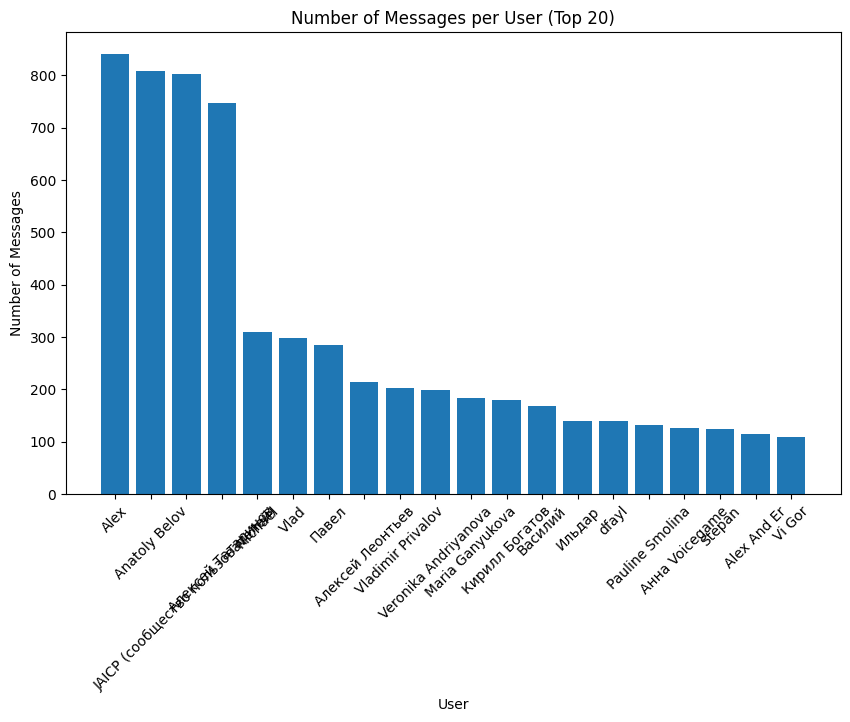

In [13]:
sorted_messages_per_user = messages_per_user.sort_values(ascending=False)

top_n = 20
top_users = sorted_messages_per_user.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_users.index, top_users.values)
plt.title('Number of Messages per User (Top 20)')
plt.xlabel('User')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

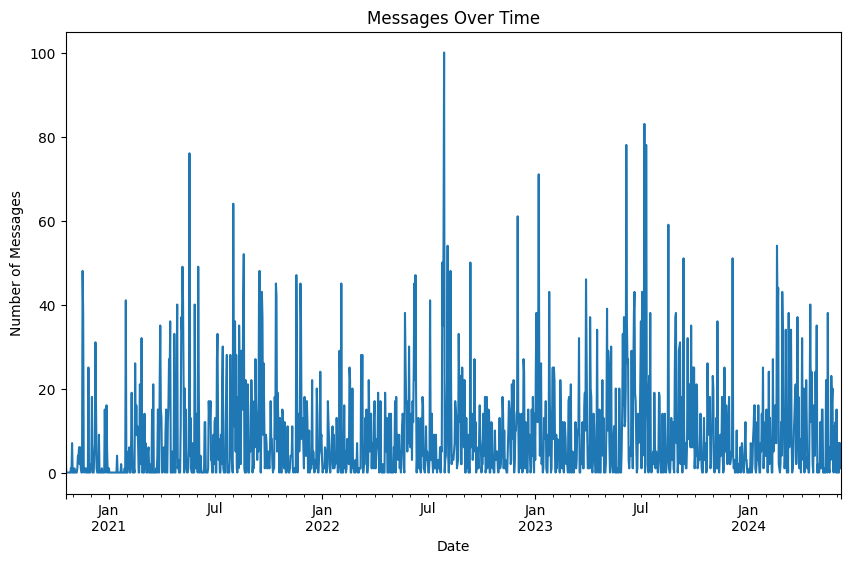

In [14]:
plt.figure(figsize=(10, 6))
messages_over_time.plot()
plt.title('Messages Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()


Пик активности как ни странно летом(в июле). в январе 24 года прям сильная просадка была. и есть ярко выражеенные пики активности, нестабилен поток сообщений, хотя сезонность есть. Посмотрим подробнее ниже

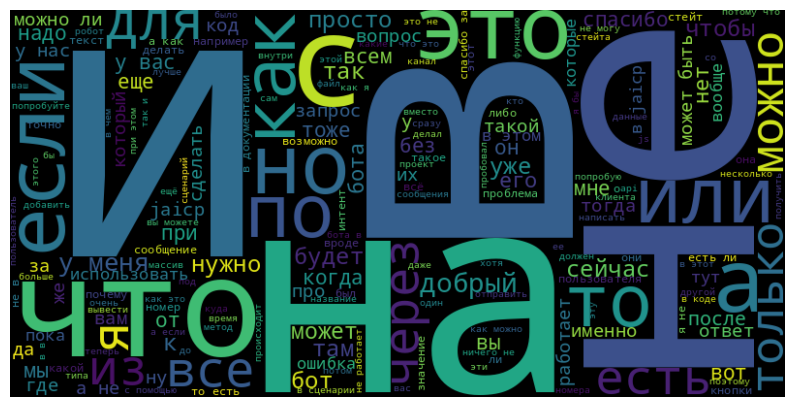

In [ ]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(all_keywords))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Много стоп - слов, избавимся от них

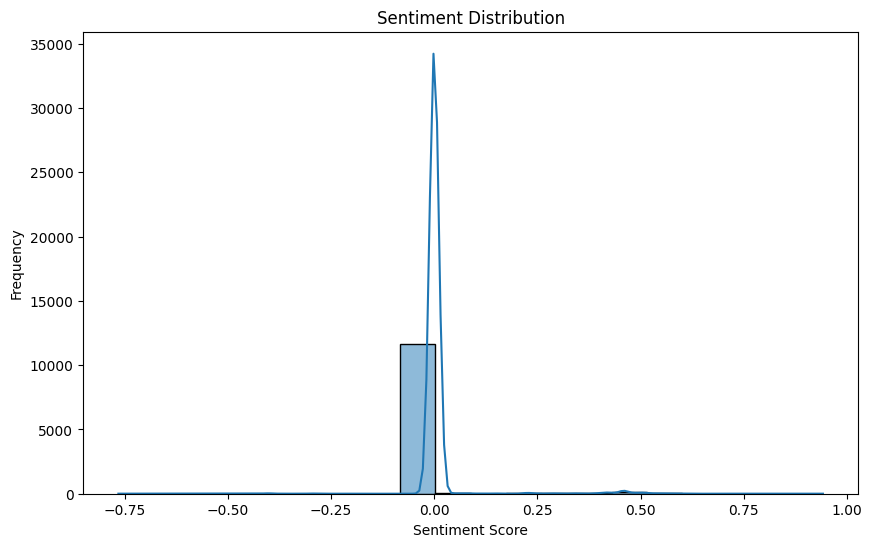

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
# Active users over time (e.g., daily)
active_users_daily = df.groupby(df['date'].dt.date)['from'].nunique()
active_users_daily


date
2020-10-19    1
2020-10-28    0
2020-10-30    2
2020-11-03    0
2020-11-08    0
             ..
2024-05-31    7
2024-06-03    5
2024-06-05    4
2024-06-06    5
2024-06-07    1
Name: from, Length: 1005, dtype: int64

In [126]:
unique_counts_df = active_users_daily.reset_index(name='unique_count')

sorted_df = unique_counts_df.sort_values(by='unique_count', ascending=False)
sorted_df.head(20)

,date,unique_count
647,2023-03-29,13
446,2022-08-04,12
464,2022-08-23,12
212,2021-10-14,12
648,2023-03-30,12
737,2023-07-17,12
389,2022-05-30,11
920,2024-02-21,11
681,2023-05-11,11
699,2023-06-06,11


максимальное количество сообщений в день - 11-13

In [17]:
# Most active users
most_active_users = messages_per_user.head(10)

# Messages per time of day
df['hour'] = df['date'].dt.hour
messages_per_hour = df['hour'].value_counts().sort_index()
messages_per_hour

hour
0      100
1       67
2       47
3       21
4       30
5       35
6       74
7      105
8      161
9      381
10     695
11    1058
12    1212
13    1003
14    1039
15    1135
16    1092
17    1195
18     804
19     501
20     380
21     285
22     319
23     216
Name: count, dtype: int64

Пик активности в рабочие часы

-----

рассмотрим ответы и вопросы подробнее

In [18]:
replies = df[df['reply_to_message_id'].notna()]
replies

,id,type,date,date_unixtime,actor,actor_id,action,text,text_entities,photo,...,reply_to_message_id,file,file_name,mime_type,thumbnail,media_type,forwarded_from,keywords,sentiment,hour
10,33,message,2020-10-30 19:43:54,1604076234,NaN,NaN,NaN,Сейчас совсем не интуитивно,"[{'type': 'plain', 'text': 'Сейчас совсем не и...",NaN,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,"[сейчас, совсем, не, интуитивно]",0.0000,19
11,34,message,2020-10-30 19:44:06,1604076246,NaN,NaN,NaN,"Всегда пожалуйста, у меня их есть много","[{'type': 'plain', 'text': 'Всегда пожалуйста,...",NaN,...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,"[всегда, у, меня, их, есть, много]",0.0000,19
27,58,message,2020-11-11 13:09:25,1605089365,NaN,NaN,NaN,"ага, спасибо!","[{'type': 'plain', 'text': 'ага, спасибо!'}]",NaN,...,56.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,13
34,65,message,2020-11-13 14:50:27,1605268227,NaN,NaN,NaN,"Спасибо за подсказку, попробую","[{'type': 'plain', 'text': 'Спасибо за подсказ...",NaN,...,64.0,NaN,NaN,NaN,NaN,NaN,NaN,"[спасибо, за, попробую]",0.0000,14
49,80,message,2020-11-17 11:42:47,1605602567,NaN,NaN,NaN,надо будет сделать ее еще более красивой 🙂 мож...,"[{'type': 'plain', 'text': 'надо будет сделать...",NaN,...,76.0,NaN,NaN,NaN,NaN,NaN,NaN,"[надо, будет, сделать, ее, еще, более, красиво...",0.4588,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11939,13611,message,2024-06-03 17:36:40,1717425400,NaN,NaN,NaN,"увидел, спасибо )","[{'type': 'plain', 'text': 'увидел, спасибо )'}]",NaN,...,13610.0,NaN,NaN,NaN,NaN,NaN,NaN,[спасибо],0.0000,17
11941,13622,message,2024-06-05 09:05:55,1717567555,NaN,NaN,NaN,"[Добрый день! Можно, например , в конфиге указ...","[{'type': 'plain', 'text': 'Добрый день! Можно...",NaN,...,13621.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,9
11945,13634,message,2024-06-05 10:59:43,1717574383,NaN,NaN,NaN,"Добрый день! Действительно, в 10:36 произошёл ...","[{'type': 'plain', 'text': 'Добрый день! Дейст...",NaN,...,13630.0,NaN,NaN,NaN,NaN,NaN,NaN,"[добрый, в, произошёл, кратковременный, сбой, ...",0.0000,10
11946,13636,message,2024-06-05 11:12:18,1717575138,NaN,NaN,NaN,Спасибо!,"[{'type': 'plain', 'text': 'Спасибо!'}]",NaN,...,13634.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,11


In [19]:
# Forwarded messages
forwarded_messages = df[df['forwarded_from'].notna()]
forwarded_messages

,id,type,date,date_unixtime,actor,actor_id,action,text,text_entities,photo,...,reply_to_message_id,file,file_name,mime_type,thumbnail,media_type,forwarded_from,keywords,sentiment,hour
1215,1283,message,2021-05-19 11:23:59,1621412639,NaN,NaN,NaN,"❗️Друзья, небольшие технические работы c исход...","[{'type': 'plain', 'text': '❗️Друзья, небольши...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic. News and updates,"[небольшие, технические, работы, c, исходящей,...",0.0,11
1216,1284,message,2021-05-19 14:57:26,1621425446,NaN,NaN,NaN,❗️Технические работы по исходящей телефонии за...,"[{'type': 'plain', 'text': '❗️Технические рабо...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic. News and updates,"[работы, по, исходящей, телефонии, работоспосо...",0.0,14
1277,1346,message,2021-05-19 18:19:14,1621437554,NaN,NaN,NaN,"Друзья, завтра, 20 мая с 18.00 до 20:00 по МСК...","[{'type': 'plain', 'text': 'Друзья, завтра, 20...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic. News and updates,"[мая, с, до, по, мск, будут, проводиться, техн...",0.0,18
1288,1357,message,2021-05-20 18:23:32,1621524212,NaN,NaN,NaN,📢📢📢\nВсем привет. Технические работы запланиро...,"[{'type': 'plain', 'text': '📢📢📢 Всем привет. Т...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic. News and updates,"[всем, технические, работы, запланированные, н...",0.0,18
1304,1373,message,2021-05-24 10:06:50,1621840010,NaN,NaN,NaN,"Друзья, сегодня, 24 мая с 18.00 до 20:00 по МС...","[{'type': 'plain', 'text': 'Друзья, сегодня, 2...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic. News and updates,"[мая, с, до, по, мск, будут, проводиться, техн...",0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10682,11290,message,2024-02-07 11:25:52,1707294352,NaN,NaN,NaN,,[],(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,Руслан Глазков,[],0.0,11
10939,11602,message,2024-02-27 16:18:59,1709039939,NaN,NaN,NaN,Добрый день!\nКорректная работа чат-виджета во...,"[{'type': 'plain', 'text': 'Добрый день! Корре...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Aimylogic (сообщество пользователей),"[добрый, корректная, работа, просим, прощения,...",0.0,16
11705,12612,message,2024-05-04 17:50:10,1714834210,NaN,NaN,NaN,"[Мы создали интент, а в нём есть в тренировочн...","[{'type': 'plain', 'text': 'Мы создали интент,...",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,Евгений Самсонов,[],0.0,17
11706,12613,message,2024-05-04 17:50:25,1714834225,NaN,NaN,NaN,Интент создавали еще для СТС и сейчас на транс...,"[{'type': 'plain', 'text': 'Интент создавали е...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Полин Дмитрий,"[интент, создавали, еще, для, стс, и, сейчас, ...",0.0,17


In [20]:
# Media types shared
media_types = df['media_type'].value_counts()
media_types

media_type
sticker       15
video_file     3
animation      2
Name: count, dtype: int64

стикеры не пользуются популярностью)

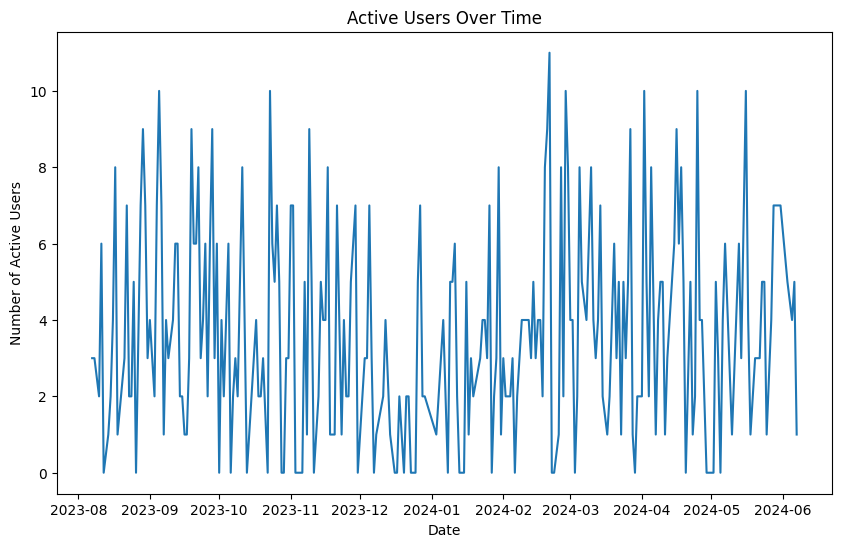

In [129]:
plt.figure(figsize=(10, 6))
active_users_daily[3*int(len(active_users_daily)/4):].plot()
plt.title('Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.show()

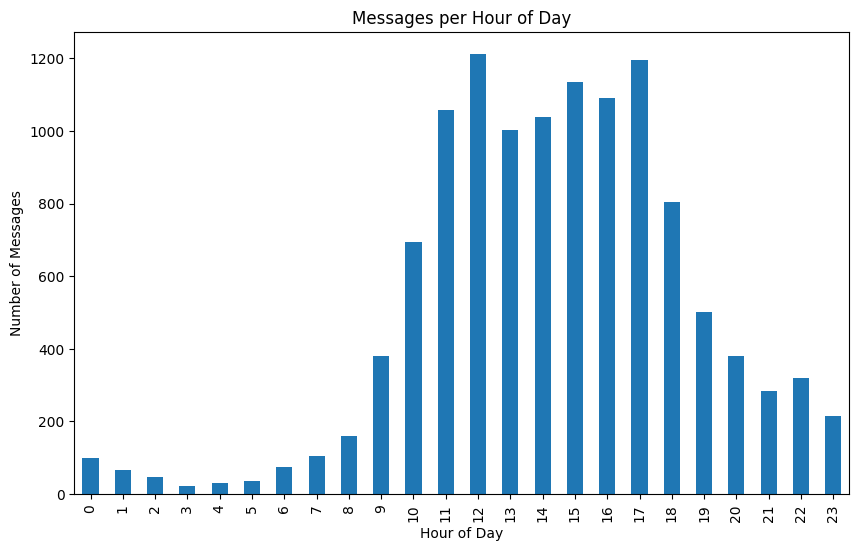

In [ ]:
plt.figure(figsize=(10, 6))
messages_per_hour.plot(kind='bar')
plt.title('Messages per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.show()

In [22]:
questions = df[df['reply_to_message_id'].isna()]
responses = df[df['reply_to_message_id'].notna()]
responses

,id,type,date,date_unixtime,actor,actor_id,action,text,text_entities,photo,...,reply_to_message_id,file,file_name,mime_type,thumbnail,media_type,forwarded_from,keywords,sentiment,hour
10,33,message,2020-10-30 19:43:54,1604076234,NaN,NaN,NaN,Сейчас совсем не интуитивно,"[{'type': 'plain', 'text': 'Сейчас совсем не и...",NaN,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,"[сейчас, совсем, не, интуитивно]",0.0000,19
11,34,message,2020-10-30 19:44:06,1604076246,NaN,NaN,NaN,"Всегда пожалуйста, у меня их есть много","[{'type': 'plain', 'text': 'Всегда пожалуйста,...",NaN,...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,"[всегда, у, меня, их, есть, много]",0.0000,19
27,58,message,2020-11-11 13:09:25,1605089365,NaN,NaN,NaN,"ага, спасибо!","[{'type': 'plain', 'text': 'ага, спасибо!'}]",NaN,...,56.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,13
34,65,message,2020-11-13 14:50:27,1605268227,NaN,NaN,NaN,"Спасибо за подсказку, попробую","[{'type': 'plain', 'text': 'Спасибо за подсказ...",NaN,...,64.0,NaN,NaN,NaN,NaN,NaN,NaN,"[спасибо, за, попробую]",0.0000,14
49,80,message,2020-11-17 11:42:47,1605602567,NaN,NaN,NaN,надо будет сделать ее еще более красивой 🙂 мож...,"[{'type': 'plain', 'text': 'надо будет сделать...",NaN,...,76.0,NaN,NaN,NaN,NaN,NaN,NaN,"[надо, будет, сделать, ее, еще, более, красиво...",0.4588,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11939,13611,message,2024-06-03 17:36:40,1717425400,NaN,NaN,NaN,"увидел, спасибо )","[{'type': 'plain', 'text': 'увидел, спасибо )'}]",NaN,...,13610.0,NaN,NaN,NaN,NaN,NaN,NaN,[спасибо],0.0000,17
11941,13622,message,2024-06-05 09:05:55,1717567555,NaN,NaN,NaN,"[Добрый день! Можно, например , в конфиге указ...","[{'type': 'plain', 'text': 'Добрый день! Можно...",NaN,...,13621.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,9
11945,13634,message,2024-06-05 10:59:43,1717574383,NaN,NaN,NaN,"Добрый день! Действительно, в 10:36 произошёл ...","[{'type': 'plain', 'text': 'Добрый день! Дейст...",NaN,...,13630.0,NaN,NaN,NaN,NaN,NaN,NaN,"[добрый, в, произошёл, кратковременный, сбой, ...",0.0000,10
11946,13636,message,2024-06-05 11:12:18,1717575138,NaN,NaN,NaN,Спасибо!,"[{'type': 'plain', 'text': 'Спасибо!'}]",NaN,...,13634.0,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0000,11


In [23]:
questions

,id,type,date,date_unixtime,actor,actor_id,action,text,text_entities,photo,...,reply_to_message_id,file,file_name,mime_type,thumbnail,media_type,forwarded_from,keywords,sentiment,hour
0,1,service,2020-10-19 16:03:40,1603112620,JAICP (сообщество пользователей),channel1327552181,migrate_from_group,,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,16
1,2,service,2020-10-19 16:06:24,1603112784,Sveta Uvarova,user46791586,edit_group_photo,,[],(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,16
2,3,message,2020-10-19 16:11:10,1603113070,NaN,NaN,NaN,[Всем привет! \nСоздала сообщество пользовател...,"[{'type': 'plain', 'text': 'Всем привет! Созд...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,16
3,4,service,2020-10-19 16:11:37,1603113097,Sveta Uvarova,user46791586,pin_message,,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,16
4,27,service,2020-10-28 14:40:23,1603885223,Anton Sipachev,user217009532,invite_members,,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,13663,message,2024-06-06 13:33:20,1717670000,NaN,NaN,NaN,Добрый день!,"[{'type': 'plain', 'text': 'Добрый день!'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[добрый],0.0,13
11951,13664,message,2024-06-06 13:36:03,1717670163,NaN,NaN,NaN,Подскажите пожалуйста как сделать так чтобы из...,"[{'type': 'plain', 'text': 'Подскажите пожалуй...",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[подскажите, пожалуйста, как, сделать, так, чт...",0.0,13
11952,13665,message,2024-06-06 13:37:40,1717670260,NaN,NaN,NaN,все стейты тут для примера,"[{'type': 'plain', 'text': 'все стейты тут для...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[все, стейты, тут, для, примера]",0.0,13
11953,13671,message,2024-06-06 15:06:35,1717675595,NaN,NaN,NaN,А в стейте Goods нельзя ли прописать тег q: с ...,"[{'type': 'plain', 'text': 'А в стейте Goods н...",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[а, в, стейте, goods, нельзя, ли, прописать, т...",0.0,15


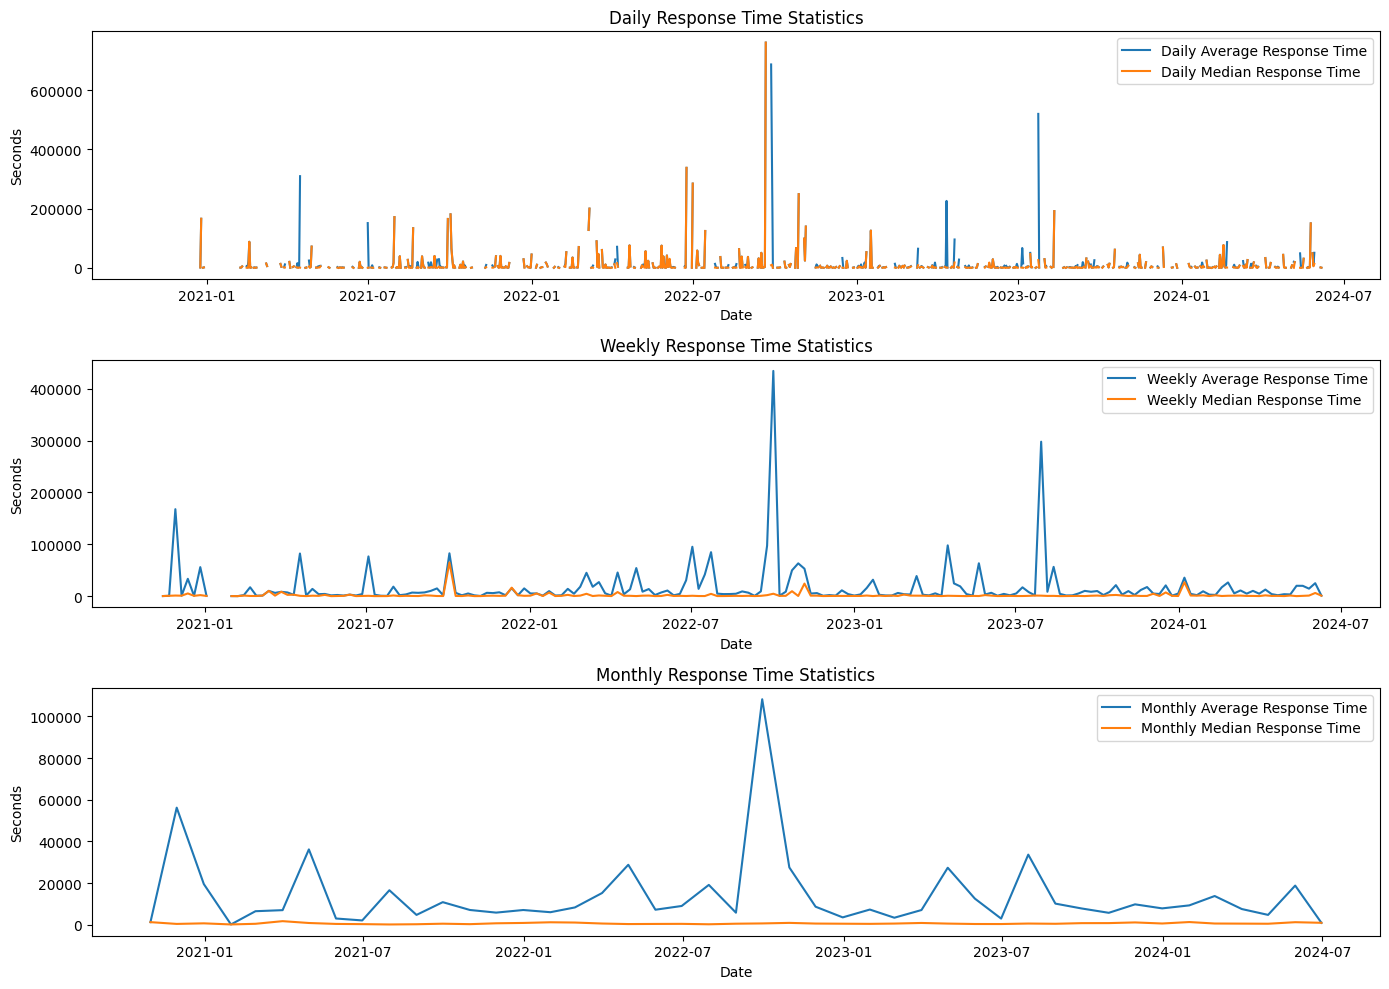

Daily Statistics:
             mean     median
count     714.00     714.00
mean    16833.30   11157.82
std     57349.69   42818.26
min         0.00       0.00
25%       553.00     267.25
50%      1988.67     782.50
75%      8164.59    3826.62
max    761483.00  761483.00
Weekly Statistics:
             mean    median
count     185.00    185.00
mean    17532.23   1838.07
std     43611.83   5675.46
min        57.50     57.50
25%      1939.20    314.00
50%      5196.52    621.00
75%     14095.73   1142.00
max    434165.62  64984.00
Monthly Statistics:
             mean   median
count      45.00    45.00
mean    13825.48   637.13
std     18088.09   341.98
min       143.50   136.00
25%      5786.64   398.00
50%      7812.78   564.00
75%     15225.26   840.50
max    108264.34  1720.00


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

first_response_times = {}


for question_id, question in questions.iterrows():

    question_responses = responses[responses['reply_to_message_id'] == question['id']]

    if not question_responses.empty:
        #первый response (мин время)
        first_response = question_responses.loc[question_responses['date'].idxmin()]
        response_time = first_response['date'] - question['date']

        first_response_times[question['id']] = response_time

response_times_df = pd.DataFrame(list(first_response_times.items()), columns=['question_id', 'response_time'])

response_times_df['response_time_seconds'] = response_times_df['response_time'].dt.total_seconds()

# Объединим время ответа с исходными данными вопроса, чтобы получить временную метку для каждого вопроса
response_times_df = response_times_df.merge(questions[['id', 'date']], left_on='question_id', right_on='id', suffixes=('', '_question'))

response_times_df.set_index('date', inplace=True)

# сами метрики
daily_stats = response_times_df['response_time_seconds'].resample('D').agg(['mean', 'median'])
weekly_stats = response_times_df['response_time_seconds'].resample('W').agg(['mean', 'median'])
monthly_stats = response_times_df['response_time_seconds'].resample('M').agg(['mean', 'median'])

# Plotting the results
plt.figure(figsize=(14, 10))

# Daily
plt.subplot(3, 1, 1)
plt.plot(daily_stats['mean'], label='Daily Average Response Time')
plt.plot(daily_stats['median'], label='Daily Median Response Time')
plt.title('Daily Response Time Statistics')
plt.xlabel('Date')
plt.ylabel('Seconds')
plt.legend()

# Weekly
plt.subplot(3, 1, 2)
plt.plot(weekly_stats['mean'], label='Weekly Average Response Time')
plt.plot(weekly_stats['median'], label='Weekly Median Response Time')
plt.title('Weekly Response Time Statistics')
plt.xlabel('Date')
plt.ylabel('Seconds')
plt.legend()

# Monthly
plt.subplot(3, 1, 3)
plt.plot(monthly_stats['mean'], label='Monthly Average Response Time')
plt.plot(monthly_stats['median'], label='Monthly Median Response Time')
plt.title('Monthly Response Time Statistics')
plt.xlabel('Date')
plt.ylabel('Seconds')
plt.legend()

plt.tight_layout()
plt.show()

# Print basic statistics
print("Daily Statistics:\n", daily_stats.describe().round(2))
print("Weekly Statistics:\n", weekly_stats.describe().round(2))
print("Monthly Statistics:\n", monthly_stats.describe().round(2))


In [25]:
questions = df[df['reply_to_message_id'].isna()]  # Messages that are not replies are questions

questions.set_index('date', inplace=True)

daily_question_count = questions['id'].resample('D').count()
weekly_question_count = questions['id'].resample('W').count()
monthly_question_count = questions['id'].resample('M').count()

print("Daily Question Count:\n", daily_question_count)
print("Weekly Question Count:\n", weekly_question_count)
print("Monthly Question Count:\n", monthly_question_count)

Daily Question Count:
 date
2020-10-19    4
2020-10-20    0
2020-10-21    0
2020-10-22    0
2020-10-23    0
             ..
2024-06-03    4
2024-06-04    0
2024-06-05    4
2024-06-06    6
2024-06-07    1
Freq: D, Name: id, Length: 1328, dtype: int64
Weekly Question Count:
 date
2020-10-25     4
2020-11-01     6
2020-11-08     2
2020-11-15    21
2020-11-22    85
              ..
2024-05-12    20
2024-05-19    37
2024-05-26    47
2024-06-02    24
2024-06-09    15
Freq: W-SUN, Name: id, Length: 190, dtype: int64
Monthly Question Count:
 date
2020-10-31     10
2020-11-30    132
2020-12-31    110
2021-01-31     32
2021-02-28    156
2021-03-31    133
2021-04-30    183
2021-05-31    221
2021-06-30    126
2021-07-31    201
2021-08-31    284
2021-09-30    196
2021-10-31    152
2021-11-30    168
2021-12-31    137
2022-01-31    114
2022-02-28    128
2022-03-31    122
2022-04-30     84
2022-05-31    169
2022-06-30    203
2022-07-31    256
2022-08-31    266
2022-09-30    121
2022-10-31    110
2022-

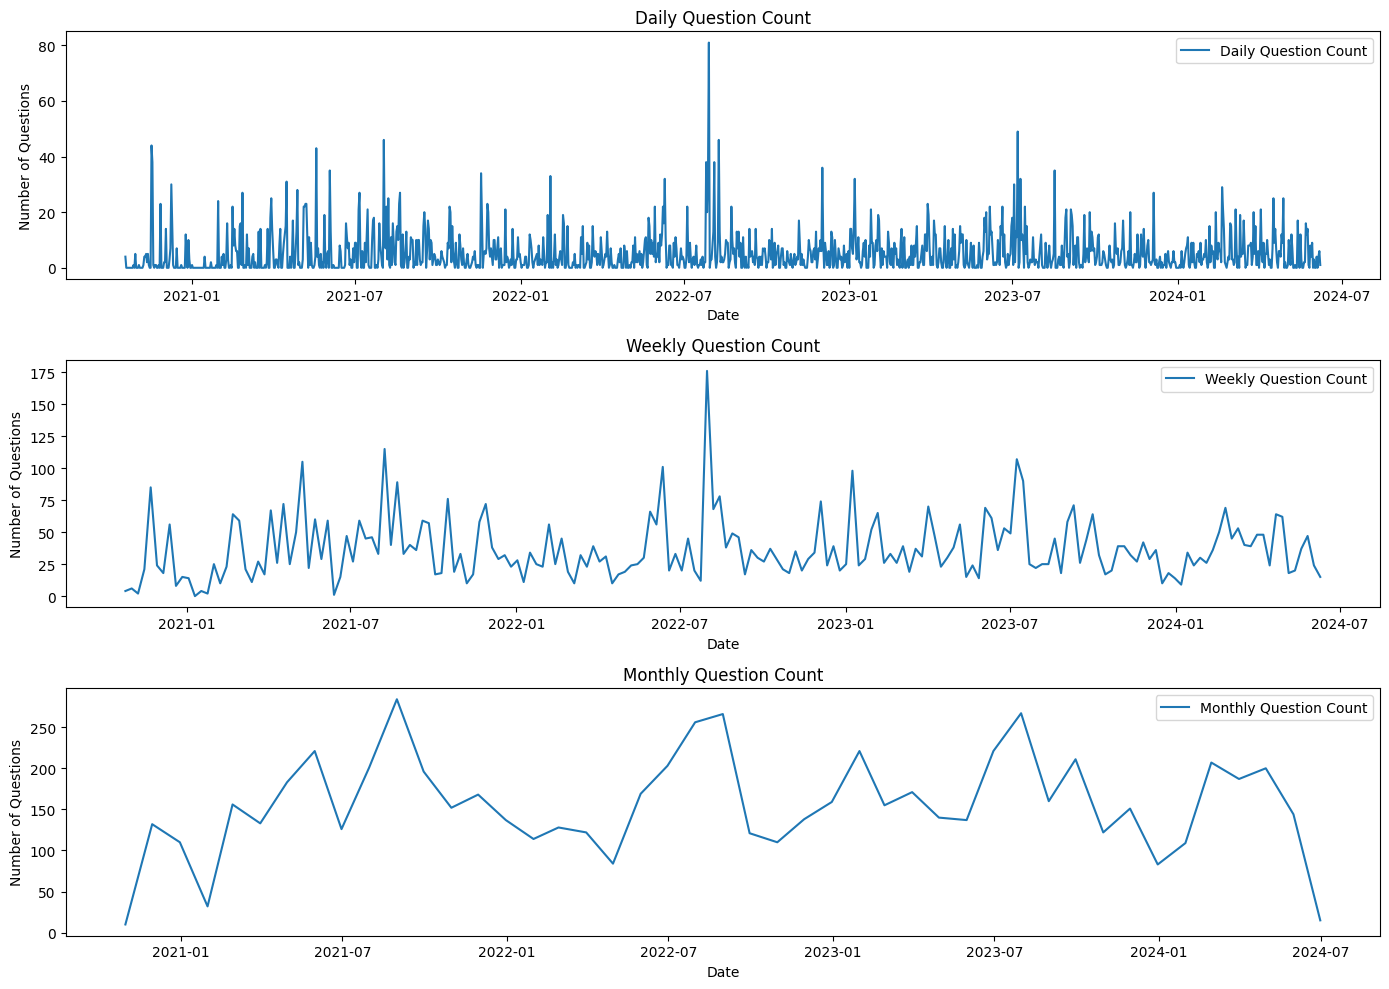

In [26]:
plt.figure(figsize=(14, 10))

# Daily
plt.subplot(3, 1, 1)
plt.plot(daily_question_count, label='Daily Question Count')
plt.title('Daily Question Count')
plt.xlabel('Date')
plt.ylabel('Number of Questions')
plt.legend()

# Weekly
plt.subplot(3, 1, 2)
plt.plot(weekly_question_count, label='Weekly Question Count')
plt.title('Weekly Question Count')
plt.xlabel('Date')
plt.ylabel('Number of Questions')
plt.legend()

# Monthly
plt.subplot(3, 1, 3)
plt.plot(monthly_question_count, label='Monthly Question Count')
plt.title('Monthly Question Count')
plt.xlabel('Date')
plt.ylabel('Number of Questions')
plt.legend()

plt.tight_layout()
plt.show()


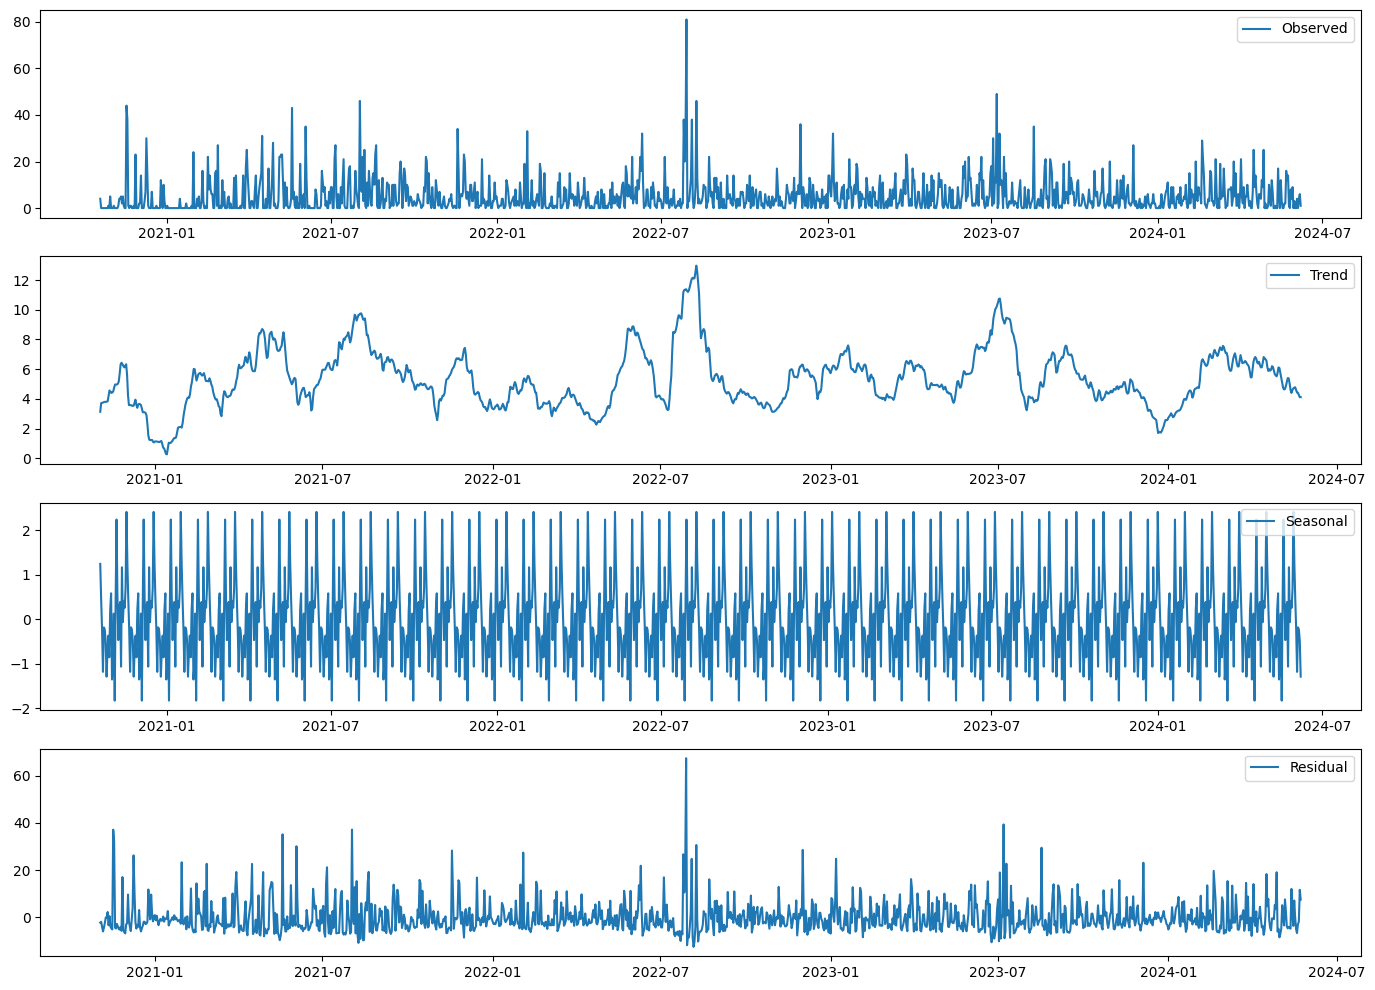

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonal decomposition of daily question count
decomposition = seasonal_decompose(daily_question_count.dropna(), model='additive', period=30)

# Plotting the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


тренда нет, сезонность есть

In [28]:
# Процент ответов на вопросы в течение 24 часов
timeframe_seconds = 24 * 3600
within_timeframe = response_times_df[response_times_df['response_time_seconds'] <= timeframe_seconds]
percentage_within_timeframe = (len(within_timeframe) / len(response_times_df)) * 100

print(f"Percentage of questions that received a response within 24 hours: {percentage_within_timeframe:.2f}%")

Percentage of questions that received a response within 24 hours: 97.32%


все проблемы решались за сутки

----

Проанализируем сами сообщения

In [44]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt
import nltk


In [64]:
# Identify questions (messages that are not replies)
questions = df[(df['reply_to_message_id'].isna()) & (df['type'] == 'message')]

# Extract and preprocess text from questions
def extract_text(text_field):
    if isinstance(text_field, list):
        return ' '.join([str(segment) for segment in text_field])
    return str(text_field)

questions['text'] = questions['text'].apply(extract_text)
questions

<ipython-input-64-b31c9783dc4d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions['text'] = questions['text'].apply(extract_text)


,id,type,date,date_unixtime,actor,actor_id,action,text,text_entities,photo,...,reply_to_message_id,file,file_name,mime_type,thumbnail,media_type,forwarded_from,keywords,sentiment,hour
2,3,message,2020-10-19 16:11:10,1603113070,NaN,NaN,NaN,Всем привет! \nСоздала сообщество пользователе...,"[{'type': 'plain', 'text': 'Всем привет! Созд...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,16
6,29,message,2020-10-30 19:18:08,1604074688,NaN,NaN,NaN,"посоны, куда жать?","[{'type': 'plain', 'text': 'посоны, куда жать?'}]",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[куда],0.0,19
7,30,message,2020-10-30 19:22:37,1604074957,NaN,NaN,NaN,Вам требуется настроить подключение по инструк...,"[{'type': 'plain', 'text': 'Вам требуется наст...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0.0,19
8,31,message,2020-10-30 19:22:56,1604074976,NaN,NaN,NaN,"Сейчас не совсем интуитивно, возьмём в работу","[{'type': 'plain', 'text': 'Сейчас не совсем и...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[сейчас, не, совсем, возьмём, в, работу]",0.0,19
9,32,message,2020-10-30 19:23:18,1604074998,NaN,NaN,NaN,Спасибо за ваше замечание!,"[{'type': 'plain', 'text': 'Спасибо за ваше за...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[спасибо, за, ваше]",0.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,13663,message,2024-06-06 13:33:20,1717670000,NaN,NaN,NaN,Добрый день!,"[{'type': 'plain', 'text': 'Добрый день!'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[добрый],0.0,13
11951,13664,message,2024-06-06 13:36:03,1717670163,NaN,NaN,NaN,Подскажите пожалуйста как сделать так чтобы из...,"[{'type': 'plain', 'text': 'Подскажите пожалуй...",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[подскажите, пожалуйста, как, сделать, так, чт...",0.0,13
11952,13665,message,2024-06-06 13:37:40,1717670260,NaN,NaN,NaN,все стейты тут для примера,"[{'type': 'plain', 'text': 'все стейты тут для...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[все, стейты, тут, для, примера]",0.0,13
11953,13671,message,2024-06-06 15:06:35,1717675595,NaN,NaN,NaN,А в стейте Goods нельзя ли прописать тег q: с ...,"[{'type': 'plain', 'text': 'А в стейте Goods н...",(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[а, в, стейте, goods, нельзя, ли, прописать, т...",0.0,15


In [103]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize the text

    # Load stopwords for both English and Russian
    stop_words_en = set(stopwords.words('english'))
    stop_words_ru = stopwords.words('russian')
    stop_words_ru.append('text')
    stop_words_ru.append('link')
    stop_words_ru.append('это')
    stop_words_ru.append('type')

    stop_words_ru.append('добрый')
    stop_words_ru.append('день')

    stop_words_ru.append('коллеги')
    stop_words_ru.append('подскажите')
    tokens = [i for i in tokens if i not in stop_words_ru]

    # Filter out English tokens and stopwords
    #tokens = [word for word in tokens if word not in stop_words_en and re.search('[а-яА-Я]', word)]
    #tokens = [word for word in tokens if word not in stop_words_ru]  # Remove Russian stopwords
    return tokens

В текстах много ссылок или "непонятных" наборов английских букв, удалим все ссылки из-за неинформативности

In [104]:
def remove_urls(text):
    url_pattern = r'https?://\S+'
    return re.sub(url_pattern, '', text)

# Apply the function to the DataFrame
questions['text_processed'] = questions['text'].apply(remove_urls)

<ipython-input-104-4a8afda0bc3c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions['text_processed'] = questions['text'].apply(remove_urls)


In [105]:
questions['text_processed']

2        Всем привет! \nСоздала сообщество пользователе...
6                                       посоны, куда жать?
7        Вам требуется настроить подключение по инструк...
8            Сейчас не совсем интуитивно, возьмём в работу
9                               Спасибо за ваше замечание!
                               ...                        
11950                                         Добрый день!
11951    Подскажите пожалуйста как сделать так чтобы из...
11952                           все стейты тут для примера
11953    А в стейте Goods нельзя ли прописать тег q: с ...
11954    Здравствуйте! А подскажите как скоро связывают...
Name: text_processed, Length: 5895, dtype: object

In [106]:
questions['text_processed'] = questions['text_processed'].apply(preprocess_text)
all_tokens = [token for sublist in questions['text_processed'] for token in sublist]

word_freq = Counter(all_tokens)
word_freq

<ipython-input-106-a79f03cc2508>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions['text_processed'] = questions['text_processed'].apply(preprocess_text)


Counter({'всем': 379,
         'привет': 408,
         'создала': 2,
         'сообщество': 3,
         'пользователей': 21,
         'платформы': 57,
         'aimylogic': 62,
         'jaicp': 382,
         'непорядок': 1,
         'пригодиться': 1,
         'тч': 2,
         'хакатона': 1,
         'нашего': 6,
         'сообщества': 4,
         'очень': 82,
         'простая': 2,
         'ссылка': 35,
         'думаю': 34,
         'разместить': 7,
         'зендеске': 2,
         'тех': 17,
         'любит': 1,
         'формат': 15,
         'чата': 11,
         'форума': 1,
         'приглашайте': 1,
         'сюда': 13,
         'коллег': 5,
         'партнеров': 2,
         'желающих': 3,
         'посоны': 1,
         'жать': 1,
         'требуется': 15,
         'настроить': 38,
         'подключение': 17,
         'инструкции': 12,
         'настроенное': 1,
         'отобразится': 3,
         'списке': 6,
         'интуитивно': 1,
         'возьмём': 2,
         'работу':

In [107]:
bigrams = [bigram for sublist in questions['text_processed'] for bigram in ngrams(sublist, 2)]
bigram_freq = Counter(bigrams)
bigram_freq

Counter({('всем', 'привет'): 280,
         ('привет', 'создала'): 1,
         ('создала', 'сообщество'): 1,
         ('сообщество', 'пользователей'): 1,
         ('пользователей', 'платформы'): 1,
         ('платформы', 'aimylogic'): 1,
         ('aimylogic', 'jaicp'): 7,
         ('jaicp', 'непорядок'): 1,
         ('непорядок', 'пригодиться'): 1,
         ('пригодиться', 'тч'): 1,
         ('тч', 'хакатона'): 1,
         ('хакатона', 'нашего'): 1,
         ('нашего', 'сообщества'): 1,
         ('сообщества', 'очень'): 1,
         ('очень', 'простая'): 1,
         ('простая', 'ссылка'): 1,
         ('ссылка', 'думаю'): 1,
         ('думаю', 'разместить'): 1,
         ('разместить', 'тч'): 1,
         ('тч', 'зендеске'): 1,
         ('зендеске', 'тех'): 1,
         ('тех', 'любит'): 1,
         ('любит', 'формат'): 1,
         ('формат', 'чата'): 1,
         ('чата', 'форума'): 1,
         ('форума', 'приглашайте'): 1,
         ('приглашайте', 'сюда'): 1,
         ('сюда', 'коллег'): 1

In [108]:
trigrams = [trigram for sublist in questions['text_processed'] for trigram in ngrams(sublist, 3)]
trigram_freq = Counter(trigrams)

In [136]:
print("Most common words:")
print(word_freq.most_common(15))

print("\nMost common bigrams:")
print(bigram_freq.most_common(15))

print("\nMost common trigrams:")
print(trigram_freq.most_common(12))

Most common words:
[('привет', 408), ('jaicp', 382), ('всем', 379), ('бота', 364), ('пожалуйста', 356), ('бот', 296), ('работает', 285), ('спасибо', 278), ('нужно', 276), ('сделать', 275), ('вопрос', 228), ('просто', 206), ('стейт', 191), ('1', 183), ('mention', 167)]

Most common bigrams:
[(('всем', 'привет'), 280), (('технические', 'работы'), 47), (('доброе', 'утро'), 41), (('данную', 'информацию'), 40), (('привет', 'пожалуйста'), 39), (('mention', 'duckling'), 39), (('учесть', 'данную'), 39), (('будут', 'проводиться'), 38), (('проводиться', 'технические'), 38), (('просьба', 'учесть'), 38), (('мск', 'будут'), 37), (('can', 'not'), 36), (('работы', 'время'), 36), (('задержки', 'ответах'), 34), (('минут', 'просьба'), 34)]

Most common trigrams:
[(('учесть', 'данную', 'информацию'), 39), (('будут', 'проводиться', 'технические'), 38), (('проводиться', 'технические', 'работы'), 38), (('просьба', 'учесть', 'данную'), 38), (('мск', 'будут', 'проводиться'), 37), (('технические', 'работы', 'в

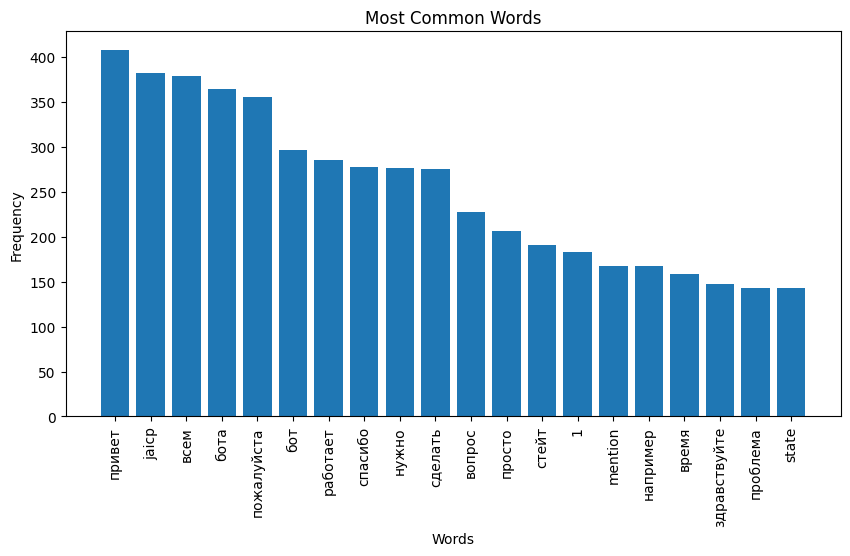

In [145]:
# Most common words
words, counts = zip(*word_freq.most_common(20))
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

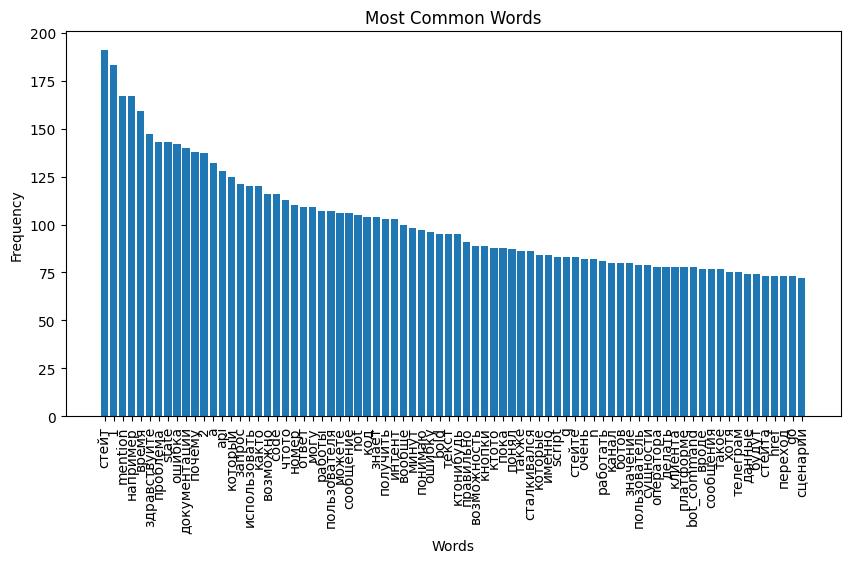

In [144]:
# Most common words
words, counts = zip(*word_freq.most_common(90)[12:])
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

можно добавить в стоп слова первые 12 слов

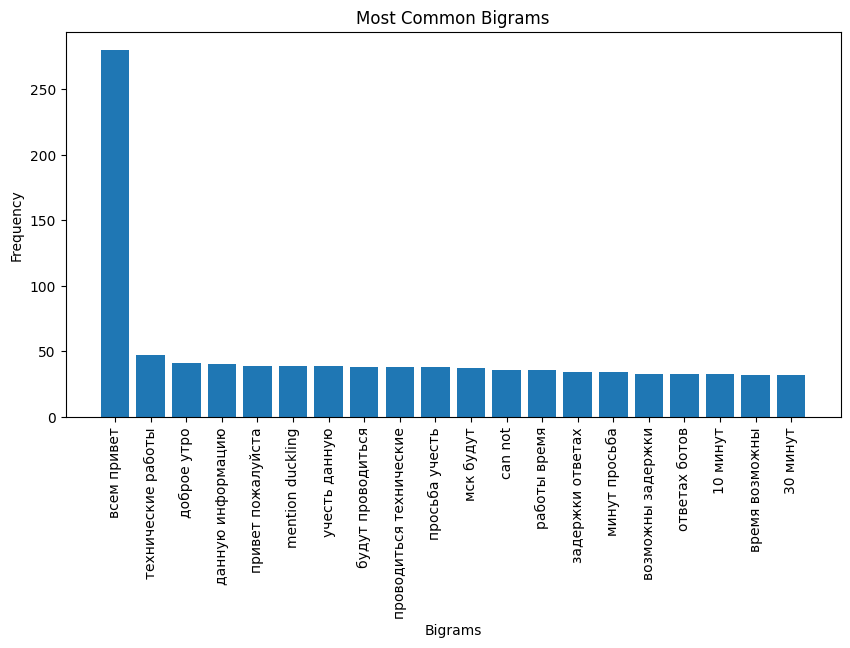

In [140]:
# Most common bigrams
bigrams, counts = zip(*bigram_freq.most_common(20))
bigram_labels = [' '.join(bigram) for bigram in bigrams]
plt.figure(figsize=(10, 5))
plt.bar(bigram_labels, counts)
plt.title('Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

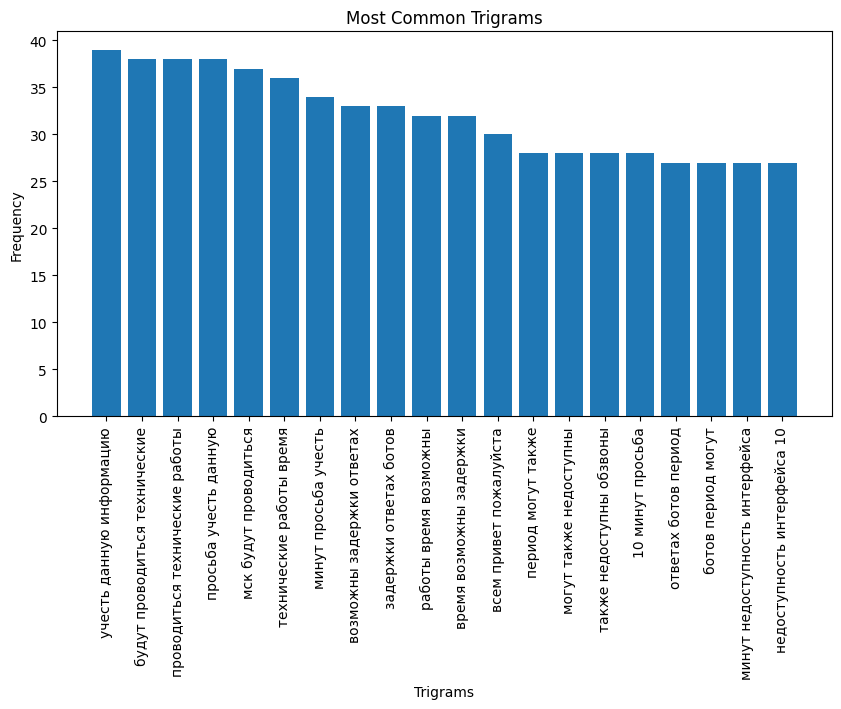

In [141]:
# Most common trigrams
trigrams, counts = zip(*trigram_freq.most_common(20))
trigram_labels = [' '.join(trigram) for trigram in trigrams]
plt.figure(figsize=(10, 5))
plt.bar(trigram_labels, counts)
plt.title('Most Common Trigrams')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Инсайты: больше всего сообщений в рабочее время с 11 утра до 18 вечера, все хорошо здороваются и благодарят